## Model Improvement

Summarize the setup and the model from the previous experiment:

#### Context
The code describes a predictive modeling setup to predict price changes over the next 10 hours based on some given features. 
The potential outcomes are:
- **+1**: The price will increase by more than +1% from the current close.
- **-1**: The price will decrease by more than -1% from the current close.
- **0**: The price change will be within +- 1% of the current close.

#### Model Structure

##### Data Preprocessing
- **Features and Targets**: Dropped 'datetime' and 'target' from features, used 'target' as label.
- **Train-Test Split**: 70% training and 30% test data.
- **Scaling**: Applied Standard Scaler to normalize feature data.
- **Handling Class Imbalance**: Used SMOTE to resample the minority class.

##### Base Models for Ensemble
1. **K-Nearest Neighbors**: A simple model for classification based on closest data points in the feature space.
2. **LightGBM**: A gradient boosting framework that uses tree-based learning algorithms.
3. **Bagging with Random Forest**: A Bagging model using RandomForest as the base estimator.
4. **Bagging with Decision Tree**: Another Bagging model but using Decision Tree as the base estimator.

##### Ensemble Strategy
- **Stacking Classifier**: Used as the final model.
    - **Base Estimators**: KNN, LightGBM, Bagging with RandomForest, and Bagging with Decision Tree.
    - **Final Estimator**: Logistic Regression.

##### Model Training
- The final stacking model is trained on the resampled (SMOTE) and scaled training data.
  
##### Evaluation Metrics (on Training Data with Cross-Validation)
- **Stacking with Logistic Regression as Final Estimator**: Mean Accuracy: 88.01%, Standard Deviation: 0.0286

##### Performance on Unseen Data
- The model was also tested on unseen data, with an overall accuracy of 78%.

##### Solution for problem with unseen data
- **Overfitting** The model may have overfit to the training data, learning the noise in the training data, but not the actual relationship between the variables.
- **Solution** Try simplifying the model, for example by reducing the number of features or changing hyperparameters.


### Current Model

In [1]:
import pandas as pd
import warnings

# Ref from data exploration
def remove_outlier(df, iqr_threshold = 5):
    
    # Calculate the first quartile (25th percentile) and third quartile (75th percentile)
    q1 = df['volume'].quantile(0.25)
    q3 = df['volume'].quantile(0.75)

    # Calculate the interquartile range (IQR)
    iqr = q3 - q1

    # Define lower and upper bounds for outliers
    lower_bound = q1 - iqr_threshold * iqr
    upper_bound = q3 + iqr_threshold * iqr

    lower_bound = 0 if lower_bound < 0 else lower_bound

    # remove outliers from df
    df = df[(df['volume'] > lower_bound) & (df['volume'] < upper_bound)]
    
    return df

def read_hist_data(name = 'BTC', timeframe = '1h'):
    file_path = f"./data/{name}_USDT-{timeframe}.json"
    df = pd.read_json(file_path)

    # set column names
    df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']

    # convert unix timestamp to datetime
    df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
    
    df = remove_outlier(df)
    return df

import talib
import numpy as np
import warnings



def get_features(df):

    # List of periods
    periods = [4, 12, 24, 48, 100, 200]
    inputs = ['high', 'low', 'close', 'volume']

    
    # loop periods and inputs
    for period in periods:
        for input in inputs:
            # Generate indicators

            # % of change
            df[f'{input}_pct_{period}'] = df[input].pct_change(periods=period) * 100

            # % of ema
            pct_ema = talib.EMA(df[input].values, timeperiod=period)
            df[f'{input}_ema_{period}'] = (df[input] - pct_ema) / pct_ema * 100

            # RSI
            df[f'{input}_rsi_{period}'] = talib.RSI(df[input].values, timeperiod=period)

            # TRIX
            df[f'{input}_trix_{period}'] = talib.TRIX(df[input].values, timeperiod=period)

            # SD
            pct_sd = talib.STDDEV(df[input].values, timeperiod=period)
            df[f'{input}_sd_{period}'] = pct_sd / df[input] * 100

            # ROC
            df[f'{input}_roc_{period}'] = talib.ROC(df[input].values, timeperiod=period)

            # VAR
            df[f'{input}_var_{period}'] = talib.VAR(df[input].values, timeperiod=period)

            # Lagged

            # pct change - lagged 1
            df[f'{input}_lag1_{period}'] = df[f'{input}_pct_{period}'].shift(1)

            # pct change - lagged 2
            df[f'{input}_lag2_{period}'] = df[f'{input}_pct_{period}'].shift(2)

            


        
        # Multiple inputs indicators
        # ATR
        pct_atr = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)
        df[f'price_atr_{period}'] = pct_atr / df['close'] * 100

        # Price interaction Features:
        df[f'price_interact_{period}'] = df[f'close_roc_{period}'] * df[f'price_atr_{period}']

        # Price volume interaction:
        df[f'pv_interact_{period}'] = df[f'close_roc_{period}'] * df[f'volume_roc_{period}']

        # ADX
        df[f'price_adx_{period}'] = talib.ADX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

        # MFI
        df[f'mfi_{period}'] = talib.MFI(df['high'].values, df['low'].values, df['close'].values, df['volume'].values, timeperiod=period)

        # DX
        df[f'price_dx_{period}'] = talib.DX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

    return df

# to predict if the price will go up (+1%) or down (-1%) in the next 10 periods
def get_target_next_close(df, target_shift = 10):

    target_treshold = 0.01
    conditions = [
        (df['close'].shift(target_shift * -1).isnull()), 
        (df['close'].shift(target_shift * -1) > df['close'] * (1+target_treshold )),
        (df['close'].shift(target_shift * -1) < df['close'] * (1-target_treshold)),
        (df['close'].shift(target_shift * -1) >= df['close'] * (1-target_treshold)) & 
        (df['close'].shift(target_shift * -1) <= df['close'] * (1+target_treshold))
    ]
    values = [np.nan, 1, -1, 0]
    df['target'] = np.select(conditions, values)
    df = df.dropna()
    return df

def get_features_target_next_close():

    # Disable the PerformanceWarning temporarily
    warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

    df = read_hist_data()
    df = get_features(df)
    df = get_target_next_close(df)

    # Re-enable warnings
    warnings.resetwarnings()

    return df

df = get_features_target_next_close()

print(df.head(5))
print(df.tail(5))

               datetime      open      high       low     close       volume  \
598 2021-01-25 22:00:00  32715.53  32732.99  31910.00  32462.36  3761.903244   
599 2021-01-25 23:00:00  32462.38  32650.00  32201.44  32254.20  2777.021592   
600 2021-01-26 00:00:00  32254.19  32793.01  31758.00  32474.33  3799.041198   
601 2021-01-26 01:00:00  32474.34  32827.33  32210.01  32758.85  2324.035401   
602 2021-01-26 02:00:00  32754.20  32765.41  32230.29  32307.97  2168.256682   

     high_pct_4  high_ema_4  high_rsi_4  high_trix_4  ...  volume_var_200  \
598   -3.815782   -1.716759    8.849644    -0.469483  ...    5.152259e+06   
599   -3.369146   -1.188915    8.175968    -0.579663  ...    5.155260e+06   
600   -2.034151   -0.455044   21.845644    -0.576277  ...    5.155131e+06   
601   -1.903168   -0.210814   25.399214    -0.506497  ...    5.153162e+06   
602    0.099044   -0.239807   22.894982    -0.426357  ...    5.140007e+06   

     volume_lag1_200  volume_lag2_200  price_atr_200  pr

In [2]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import joblib

# Train model: Stacking Classifier with Logistic Regression as the final estimator
def train_model_stacking_lr(X, y, random_state = 55, print_report = True, model_name = 'btc_10h_direction', model_path = './models/'):
    # Data Preprocessing: Splitting and Scaling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # save scaler
    scaler_filepath = model_path + model_name + '_scaler.joblib'
    joblib.dump(scaler, scaler_filepath)

    # Data Augmentation: SMOTE for imbalance handling
    sm = SMOTE(random_state=random_state)
    X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

    # Initialize Bagging Classifiers

    bagging_rf = BaggingClassifier(estimator=RandomForestClassifier(random_state=random_state, n_jobs=-1),
                                n_estimators=10, random_state=random_state, n_jobs=-1)

    bagging_dt = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=random_state),
                                n_estimators=10, random_state=random_state, n_jobs=-1)

    # Initialize base estimators for stacking
    base_estimators = [
        ('knn', KNeighborsClassifier(n_jobs=-1)),
        ('lgbm', lgb.LGBMClassifier(random_state=random_state, n_jobs=-1, verbose=-1)),
        ('bagging_rf', bagging_rf),
        ('bagging_dt', bagging_dt),
        
    ]

    # Initialize the final Stacking Classifier with Logistic Regression as the final estimator
    model = StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression(max_iter=10000), n_jobs=-1)

    # Train the final Stacking model
    model.fit(X_train_res, y_train_res)

    # save model
    model_filepath = model_path + model_name + '_model.joblib'
    joblib.dump(model, model_filepath)

    if print_report:
        # Evaluate the final Stacking model with classification_report
        y_pred = model.predict(X_test_scaled)
        print(classification_report(y_test, y_pred))
    
    
    return model


In [94]:
# Separate features and target
X = df.drop(columns=['datetime', 'target'])
y = df['target']

# Train the model
model = train_model_stacking_lr(X, y)


              precision    recall  f1-score   support

        -1.0       0.77      0.70      0.74      1583
         0.0       0.78      0.83      0.80      3534
         1.0       0.78      0.73      0.75      1576

    accuracy                           0.77      6693
   macro avg       0.77      0.75      0.76      6693
weighted avg       0.77      0.77      0.77      6693



##### Test the model with live data

In [95]:
# Fetch BTCUSDT-1h data 500 rows from binance API
import requests
import pandas as pd
import json
import time
import datetime
import numpy as np
import warnings

def format_live_binance_data(df):

    # use only completed hour
    df = df[df['close_time'] <= datetime.datetime.now(datetime.timezone.utc).strftime("%Y-%m-%d %H:%M:%S")] 

    df_live = pd.DataFrame()
    df_live['datetime'] = df['open_time']
    df_live['open'] = df['open']
    df_live['high'] = df['high']
    df_live['low'] = df['low']
    df_live['close'] = df['close']
    df_live['volume'] = df['volume']
    
    return df_live

def fetch_live_binance_data(name = 'BTC', timeframe = '1h', limit = 1000):
    url = f"https://api.binance.com/api/v3/klines?symbol={name}USDT&interval={timeframe}&limit={limit}"
    response = requests.get(url)
    df = pd.DataFrame(json.loads(response.text))
    df.columns = ['open_time',
                'open', 'high', 'low', 'close', 'volume',
                'close_time', 'quote_asset_volume', 'number_of_trades',
                'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    
    df = df.astype(float)
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')

    df = format_live_binance_data(df)
    return df

df_live = fetch_live_binance_data()

print(df_live.head(5))
print(df_live.tail(5))

             datetime      open      high       low     close      volume
0 2023-07-17 14:00:00  30286.65  30308.00  30230.38  30274.80  1020.42617
1 2023-07-17 15:00:00  30274.81  30291.74  30112.99  30174.83   968.95706
2 2023-07-17 16:00:00  30174.84  30241.03  30078.00  30144.01  1466.07769
3 2023-07-17 17:00:00  30144.00  30159.99  29920.00  30030.67  2742.68881
4 2023-07-17 18:00:00  30030.67  30060.00  29659.20  29802.39  4222.31153
               datetime      open      high       low     close      volume
994 2023-08-28 00:00:00  26101.78  26105.00  25986.41  26023.51  1227.44710
995 2023-08-28 01:00:00  26023.51  26063.39  25993.58  26028.01   857.51904
996 2023-08-28 02:00:00  26028.02  26056.93  26019.53  26030.50   481.96317
997 2023-08-28 03:00:00  26030.49  26050.75  26012.98  26012.98   742.29889
998 2023-08-28 04:00:00  26012.98  26038.83  26009.37  26026.61   514.74670


##### Calculate feature values for live data

In [96]:
# Disable the PerformanceWarning temporarily
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

X_live = df_live.copy()
X_live = get_features(X_live)
X_live.dropna(inplace=True)

# Re-enable warnings
warnings.resetwarnings()

In [97]:
def predict_live_data(X_live, model_name = 'btc_10h_direction', model_path = './models/'):
    # Separate features and target
    X_live_features = X_live.drop(columns=['datetime'])

    # load scaler
    scaler_filepath = model_path + model_name + '_scaler.joblib'
    scaler = joblib.load(scaler_filepath)
    X_live_scaled = scaler.transform(X_live_features)

    # load model
    model_filepath = model_path + model_name + '_model.joblib'
    model = joblib.load(model_filepath)

    # predict
    y_pred = model.predict(X_live_scaled)

    # match prediction with live data
    X_live = X_live.copy() # fix fragmented
    X_live['prediction'] = y_pred

    return X_live

y_live_pred = predict_live_data(X_live)


Classification Report:
               precision    recall  f1-score   support

        -1.0       0.94      0.64      0.76        45
         0.0       0.94      0.99      0.96       333
         1.0       0.67      0.31      0.42        13

    accuracy                           0.93       391
   macro avg       0.85      0.65      0.72       391
weighted avg       0.93      0.93      0.92       391



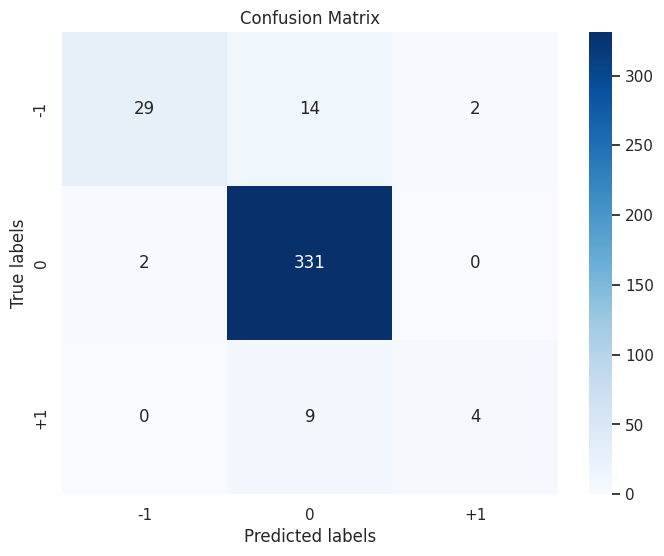

In [101]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_live_data(y_pred):
    pred_result = y_pred[['datetime', 'close', 'prediction']].copy()

    pred_target = get_target_next_close(pred_result)

    # Confusion report
    print("\nClassification Report:\n", classification_report(pred_target['target'], pred_target['prediction']))

    # 1. Confusion Matrix
    conf_matrix = confusion_matrix(pred_target['target'], pred_target['prediction'])

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
                xticklabels=['-1', '0', '+1'], 
                yticklabels=['-1', '0', '+1'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_live_data(y_live_pred)

The model performs exceptionally well for the majority class (0.0) but struggles to effectively identify instances of the minority classes (-1.0 and 1.0). 
- High precision but low recall for the minority classes indicates that when the model predicts these classes, it is usually correct, but it also misses a significant number of instances that it should have caught.

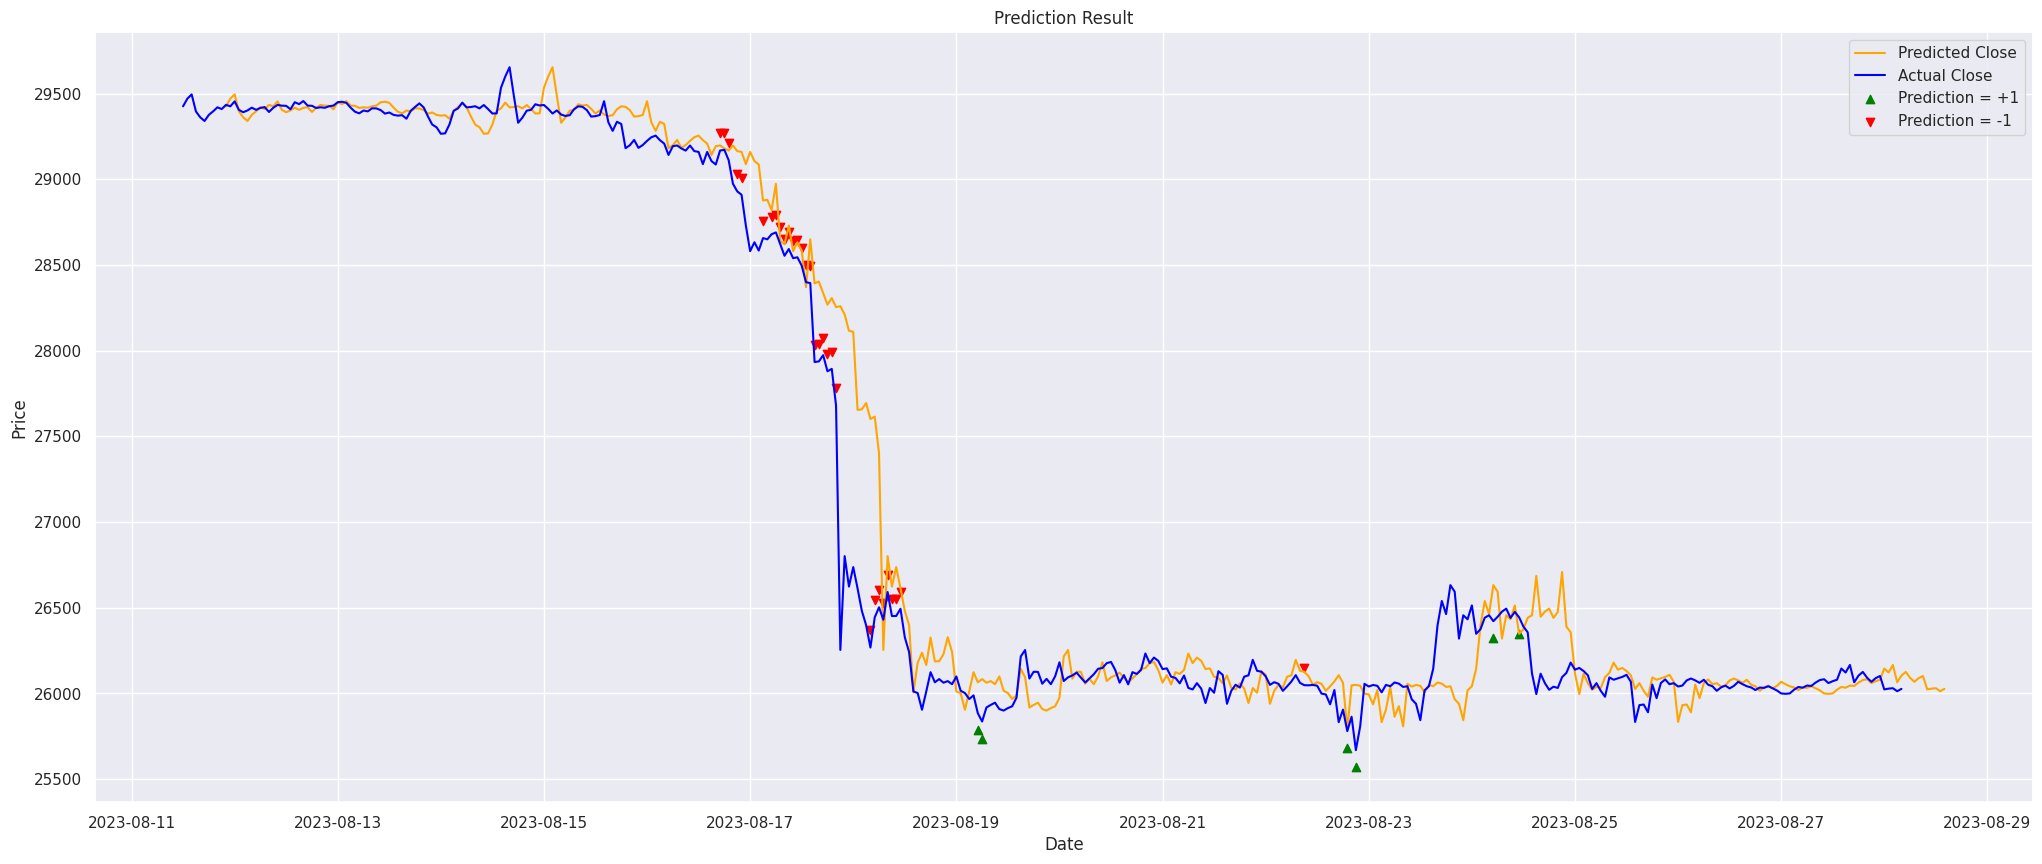

In [135]:
def plot_live_data(y_pred, target_treshold = 0.01, target_shift = 10):
    pred_result = y_pred[['datetime', 'close', 'prediction']].copy()

    # Calculate future close price, if prediction is 1, then close price will be 1% higher, if prediction is -1, then close price will be 1% lower
    pred_result['future_close'] = pred_result['close'] * (1 + pred_result['prediction'] * target_treshold)

    # Extend the prediction to the future
    date_range = pd.date_range(start=pred_result['datetime'].iloc[-1], periods=(target_shift+1), freq='H')
    # remove first row of date_range
    date_range = date_range[1:]

    pred_result_future = pd.DataFrame()
    pred_result_future['datetime'] = date_range
    pred_result_future['close'] = np.nan
    pred_result_future['prediction'] = np.nan
    pred_result_future['future_close'] = np.nan

    # concat pred_result and pred_result_future
    pred_result = pd.concat([pred_result, pred_result_future])

    # shift future_close 10 periods up
    pred_result['future_close'] = pred_result['future_close'].shift(target_shift)

    # plot 2 lines of close and future_close with sns
    plt.figure(figsize=(25, 10))
    
    sns.lineplot(data=pred_result, x='datetime', y='future_close', label='Predicted Close', color='orange')
    sns.lineplot(data=pred_result, x='datetime', y='close', label='Actual Close', color='blue')

    plt.scatter(
        pred_result[pred_result['prediction'] == 1]['datetime'], 
        pred_result[pred_result['prediction'] == 1]['close'] - 100, 
        color='green', 
        marker='^', 
        label='Prediction = +1'
    )

    # Plot scatter points for negative predictions
    plt.scatter(
        pred_result[pred_result['prediction'] == -1]['datetime'], 
        pred_result[pred_result['prediction'] == -1]['close'] + 100, 
        color='red', 
        marker='v',
        label='Prediction = -1'
    )

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Prediction Result')
    plt.legend()
    plt.show()


# print(y_live_pred.tail(5))
plot_live_data(y_live_pred)

----

### Experiment 1: Improvement with Feature Selection

The large number of features can add noise or collinearity, which can lead to overfitting. We could improve by reducing the number of features.

1. **Feature Importance**: Use algorithms like Random Forests or XGBoost to identify important features. Drop those which do not contribute much to the target variable.
   
2. **Correlation Analysis**: Remove highly correlated features as they can cause multicollinearity problems.

##### Feature Importance

Refer from least important features in previous experiment, we will drop them and test the model again.
- RSIs, EMAs, and ROCs

We consider adding more information for the top important features:
- ATR lagged

Lastly, we try to reduce the number of periods to save computation time:

In [5]:
def get_features_v2(df):

    # List of periods
    periods = [10, 20, 50, 100, 200]
    inputs = ['high', 'low', 'close', 'volume']

    
    # loop periods and inputs
    for period in periods:
        for input in inputs:
            # Generate indicators

            # % of change
            df[f'{input}_pct_{period}'] = df[input].pct_change(periods=period) * 100

            # TRIX
            df[f'{input}_trix_{period}'] = talib.TRIX(df[input].values, timeperiod=period)

            # SD
            pct_sd = talib.STDDEV(df[input].values, timeperiod=period)
            df[f'{input}_sd_{period}'] = pct_sd / df[input] * 100

            # VAR
            df[f'{input}_var_{period}'] = talib.VAR(df[input].values, timeperiod=period)

            df = df.copy()

            


        
        # Multiple inputs indicators
        # ATR
        pct_atr = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)
        df[f'price_atr_{period}'] = pct_atr / df['close'] * 100

        # ATR - lagged 1
        df[f'price_atr_lag1_{period}'] = df[f'price_atr_{period}'].shift(1)

        # ATR - lagged 2
        df[f'price_atr_lag2_{period}'] = df[f'price_atr_{period}'].shift(2)

        # Price interaction Features:
        df[f'price_interact_{period}'] = df[f'close_pct_{period}'] * df[f'price_atr_{period}']

        # Price volume interaction:
        df[f'pv_interact_{period}'] = df[f'close_pct_{period}'] * df[f'volume_pct_{period}']

        # ADX
        df[f'price_adx_{period}'] = talib.ADX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

        # MFI
        df[f'mfi_{period}'] = talib.MFI(df['high'].values, df['low'].values, df['close'].values, df['volume'].values, timeperiod=period)

        # DX
        df[f'price_dx_{period}'] = talib.DX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

        df = df.copy()

    return df

def get_features_v2_target_next_close():

    df = read_hist_data()
    df = get_features_v2(df)
    df = get_target_next_close(df)

    return df

df = get_features_v2_target_next_close()



In [6]:
print(df.head(5))
print(df.tail(5))   

print(f'Total columns: {len(df.columns)}')

               datetime      open      high       low     close       volume  \
598 2021-01-25 22:00:00  32715.53  32732.99  31910.00  32462.36  3761.903244   
599 2021-01-25 23:00:00  32462.38  32650.00  32201.44  32254.20  2777.021592   
600 2021-01-26 00:00:00  32254.19  32793.01  31758.00  32474.33  3799.041198   
601 2021-01-26 01:00:00  32474.34  32827.33  32210.01  32758.85  2324.035401   
602 2021-01-26 02:00:00  32754.20  32765.41  32230.29  32307.97  2168.256682   

     high_pct_10  high_trix_10  high_sd_10    high_var_10  ...  \
598    -4.568542      0.127206    1.981095  420515.414542  ...   
599    -5.891319      0.070057    2.236237  533091.604260  ...   
600    -5.969864      0.017296    2.144141  494389.700350  ...   
601    -5.092822     -0.027989    2.016728  438294.373684  ...   
602    -5.302283     -0.066215    1.735132  323218.431721  ...   

     volume_var_200  price_atr_200  price_atr_lag1_200  price_atr_lag2_200  \
598    5.152259e+06       2.221715          

In [209]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

random_state=55

# Assuming df is the DataFrame with features and target variable
# Separate features and target
X = df.drop(columns=['datetime', 'target'])
y = df['target']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

# Initialize and train the model
clf = RandomForestClassifier(random_state=random_state, n_jobs=-1)
clf.fit(X_train, y_train)

# Get feature importances
feature_importances = clf.feature_importances_

# Sort feature importances in descending order and get the indices
indices = np.argsort(feature_importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
feature_names = [X.columns[i] for i in indices]


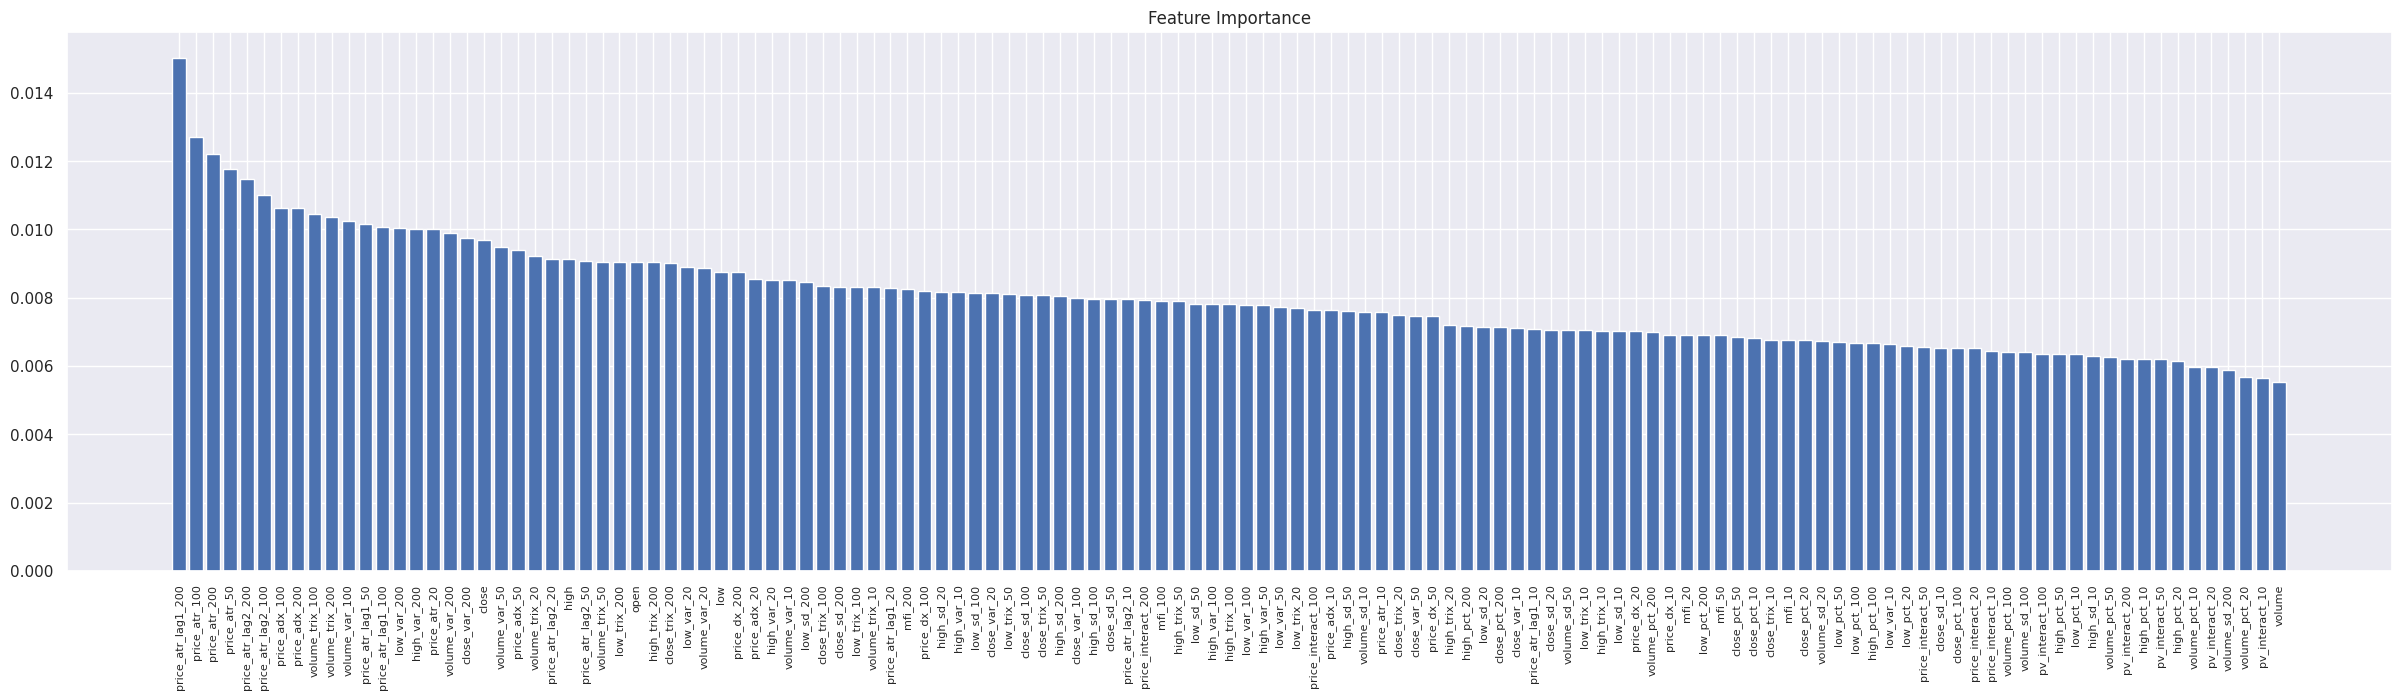

Total features: 125
Top 25 important features:  ['price_atr_lag1_200', 'price_atr_100', 'price_atr_200', 'price_atr_50', 'price_atr_lag2_200', 'price_atr_lag2_100', 'price_adx_100', 'price_adx_200', 'volume_trix_100', 'volume_trix_200', 'volume_var_100', 'price_atr_lag1_50', 'price_atr_lag1_100', 'low_var_200', 'high_var_200', 'price_atr_20', 'volume_var_200', 'close_var_200', 'close', 'volume_var_50', 'price_adx_50', 'volume_trix_20', 'price_atr_lag2_20', 'high', 'price_atr_lag2_50']
Least 25 important features:  ['high_pct_100', 'low_var_10', 'low_pct_20', 'price_interact_50', 'close_sd_10', 'close_pct_100', 'price_interact_20', 'price_interact_10', 'volume_pct_100', 'volume_sd_100', 'pv_interact_100', 'high_pct_50', 'low_pct_10', 'high_sd_10', 'volume_pct_50', 'pv_interact_200', 'high_pct_10', 'pv_interact_50', 'high_pct_20', 'volume_pct_10', 'pv_interact_20', 'volume_sd_200', 'volume_pct_20', 'pv_interact_10', 'volume']


In [210]:
# Create a plot
plt.figure(figsize=(30, 7))

# Create plot title
plt.title("Feature Importance")

# Add bars for each feature, small font size to fit the features
plt.bar(range(X.shape[1]), feature_importances[indices] )

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), feature_names, rotation=90, fontsize = 8)

# Show plot
plt.show()

# print total features
print(f'Total features: {len(feature_names)}')

# print most important 25 features
print("Top 25 important features: ", feature_names[:25])

# print least important 25 features
print("Least 25 important features: ", feature_names[-25:])


In [211]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Predict labels for the test set
y_pred = clf.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Use weighted average if classes are imbalanced
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy:0.4f}")
print(f"F1-Score: {f1:0.4f}")
print(f"Precision: {precision:0.4f}")
print(f"Recall: {recall:0.4f}")

Accuracy: 0.7978
F1-Score: 0.7956
Precision: 0.8016
Recall: 0.7978


##### Observations

1. **Improved Performance**: After reducing the number of features, all the performance metrics improved.
2. **Feature Importance**: By narrowing down to important features, the model seems to have reduced noise and therefore improved its generalization capability.
3. **Lagged Features**: Introducing lagged features ('price_atr_lag1_200', 'price_atr_lag2_200') appeared beneficial.
4. **Overfitting**: The model initially suffered from overfitting due to too many features, but this seemed to have been improved by feature reduction.

##### Rebuild the model with the new features

In [213]:
# Separate features and target
X = df.drop(columns=['datetime', 'target'])
y = df['target']

# Train the model
model = train_model_stacking_lr(X, y, model_name = 'btc_10h_direction_v2')

              precision    recall  f1-score   support

        -1.0       0.78      0.77      0.77      1583
         0.0       0.81      0.82      0.82      3534
         1.0       0.80      0.79      0.79      1576

    accuracy                           0.80      6693
   macro avg       0.80      0.79      0.80      6693
weighted avg       0.80      0.80      0.80      6693



##### Observations

1. **Improved Performance**: Your performance metrics have improved across all classes and overall after the feature reduction. This validates that your approach to feature selection was effective.
  
2. **Balanced Class-wise Metrics**: Your model appears to be balanced across classes after the feature reduction, showing no significant bias towards any specific class.

3. **Overall Consistency**: All metrics such as precision, recall, F1-score, and accuracy have improved, suggesting that the model is likely more robust and generalizable than before.

##### Next Steps

- **Hyperparameter Tuning**: Experimenting with the model hyperparameters might yield even better results.

----

### Experiment 2: Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Function for hyperparameter tuning
def tune_model_stacking_lr(X, y, random_state=55, cv_folds=5):
    
    # Data Preprocessing: Splitting and Scaling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Data Augmentation: SMOTE
    sm = SMOTE(random_state=random_state)
    X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

    # Initialize base classifiers
    knn = KNeighborsClassifier()
    lgbm = lgb.LGBMClassifier()
    rf = RandomForestClassifier()
    dt = DecisionTreeClassifier()
    
    # Hyperparameter grid for each base classifier
    knn_params = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
    lgbm_params = {'learning_rate': [0.01, 0.1], 'n_estimators': [50, 100]}
    rf_params = {'n_estimators': [10, 50], 'max_depth': [None, 10, 20]}
    dt_params = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20]}
    lr_params = {'C': [0.1, 1, 10]}
    
    # Create grid for Stacking Classifier
    param_grid = [
        {
            'knn__n_neighbors': knn_params['n_neighbors'],
            'knn__weights': knn_params['weights'],
            'lgbm__learning_rate': lgbm_params['learning_rate'],
            'lgbm__n_estimators': lgbm_params['n_estimators'],
            'bagging_rf__base_estimator__n_estimators': rf_params['n_estimators'],
            'bagging_rf__base_estimator__max_depth': rf_params['max_depth'],
            'bagging_dt__base_estimator__criterion': dt_params['criterion'],
            'bagging_dt__base_estimator__max_depth': dt_params['max_depth'],
            'final_estimator__C': lr_params['C']
        }
    ]
    
    # Initialize Bagging Classifiers
    bagging_rf = BaggingClassifier(estimator=RandomForestClassifier(n_jobs=-1), n_estimators=10, random_state=random_state, n_jobs=-1)
    bagging_dt = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=random_state, n_jobs=-1)

    # Initialize base estimators for stacking
    base_estimators = [
        ('knn', knn),
        ('lgbm', lgbm),
        ('bagging_rf', bagging_rf),
        ('bagging_dt', bagging_dt)
    ]
    
    # Initialize Stacking Classifier
    model = StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression(max_iter=10000), n_jobs=-1)
    
    # Initialize GridSearch
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                               cv=cv_folds, n_jobs=-1, verbose=2)
    
    # Perform hyperparameter search
    grid_search.fit(X_train_res, y_train_res)
    
    return grid_search.best_params_, grid_search.best_estimator_

# Run hyperparameter tuning
best_params, best_model = tune_model_stacking_lr(X, y)
print(f"Best parameters: {best_params}")


The optimization has been running **more than 24 hours and still not finished**. I decided to stop the optimization and use the best parameters found so far.

##### Alternative ways to speed up the process:

**1. Randomized Search**

Instead of an exhaustive grid search, use a randomized search. It samples a fixed number of parameter combinations from the specified hyperparameter space. This can be more efficient and quicker.

**2. Coarse-to-Fine Tuning**

First perform a rough search over a wide range of parameter values, and then perform a more focused search around the best parameters found.

**3. Parallelization**

Increase the number of workers in the search, setting `n_jobs=-1` will use all available CPUs to perform the search.

**4. Early Stopping**

For algorithms that support it (e.g., gradient boosting, neural networks), you can set early stopping rules to halt the training process when it's clear the model is not improving.

**5. Bayesian Optimization**

This is a probabilistic model based optimization technique, and is more efficient than grid and random search. Libraries like `Hyperopt` or `Optuna` can be used for Bayesian Optimization.

**6. Reduce Data Size**

For a quicker run time, you can perform the hyperparameter tuning steps on a smaller subset of your data. Once the best parameters are found, you can use them to train the model on the complete dataset.

**7. Incremental Training**

If your model allows for incremental training (also known as "warm starting"), you can train it in chunks to allow for more iterative model updates.

**8. Pre-emption**

Some optimization frameworks allow you to preemptively halt the least promising trials before they complete, based on interim results.

**9. Ensemble of Best Models**

Instead of searching for one set of optimal parameters, you can train multiple models with different parameters and ensemble their predictions.

**10. Checkpointing**

Save the model and its best parameters periodically during training, so you can stop and restart the optimization process at will.

----

### Experiment 3: Hyperparameter Tuning with Ensemble of Best Models Approach

Long running times during hyperparameter optimization are common, especially when the parameter space is large and the model is complex. 
- I decide to use the ensemble of best models approach to spit the hyperparameter tuning into multiple runs. 
- Then I will stack the best models from each run to form the final model.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np


df = get_features_v2_target_next_close()

random_state=55

# Separate features and target
X = df.drop(columns=['datetime', 'target'])
y = df['target']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE
sm = SMOTE(random_state=random_state)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

Load modules

In [11]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

##### Step 1: Tune Each Base Model Separately and Save Best Parameters

1.1 K-Nearest Neighbors

In [15]:
# Parameter grid for KNN
param_grid_knn = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
grid_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid_knn, n_jobs=-1, cv=5)
grid_knn.fit(X_train_res, y_train_res)

# Save best parameters
best_params_knn = grid_knn.best_params_
print(f"Best parameters for KNN:", best_params_knn)

Best parameters for KNN: {'n_neighbors': 3, 'weights': 'distance'}


In [16]:
# predict with original model
model = KNeighborsClassifier(n_jobs=-1)
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test_scaled)

# print original score
print("\nClassification Report (Original Model):\n", classification_report(y_test, y_pred))

# predict with best model
model = KNeighborsClassifier(**best_params_knn, n_jobs=-1)
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test_scaled)

# print best score
print("\nClassification Report (Best Model):\n", classification_report(y_test, y_pred))


Classification Report (Original Model):
               precision    recall  f1-score   support

        -1.0       0.65      0.82      0.73      1583
         0.0       0.85      0.68      0.76      3534
         1.0       0.70      0.82      0.76      1576

    accuracy                           0.75      6693
   macro avg       0.73      0.78      0.75      6693
weighted avg       0.77      0.75      0.75      6693


Classification Report (Best Model):
               precision    recall  f1-score   support

        -1.0       0.71      0.82      0.76      1583
         0.0       0.84      0.74      0.78      3534
         1.0       0.73      0.82      0.77      1576

    accuracy                           0.78      6693
   macro avg       0.76      0.79      0.77      6693
weighted avg       0.78      0.78      0.78      6693



1.2 LightGBM

In [11]:
# Suppress the DeprecationWarning temporarily
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Parameter grid for LightGBM
param_grid_lgb = {'n_estimators': [50, 100, 150, 200, 250], 'learning_rate': [0.05, 0.1, 0.15], 'num_leaves': [31, 62, 124]}
grid_lgb = GridSearchCV(lgb.LGBMClassifier(random_state=random_state, n_jobs=-1, verbose=-1), param_grid=param_grid_lgb, cv=5)
grid_lgb.fit(X_train_res, y_train_res)

# Save best parameters
best_params_lgb = grid_lgb.best_params_
print("Best Parameters for LightGBM:", best_params_lgb)

Best Parameters for RandomForest: {'learning_rate': 0.15, 'n_estimators': 250, 'num_leaves': 124}


In [13]:
# predict with original model
model = lgb.LGBMClassifier(random_state=random_state, n_jobs=-1, verbose=-1)
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test_scaled)

# print original score
print("\nClassification Report (Original Model):\n", classification_report(y_test, y_pred))

# predict with best model
model = lgb.LGBMClassifier(**best_params_lgb, random_state=random_state, n_jobs=-1, verbose=-1)
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test_scaled)

# print best score
print("\nClassification Report (Best Model):\n", classification_report(y_test, y_pred))

# Re-enable warnings
warnings.resetwarnings()


Classification Report (Original Model):
               precision    recall  f1-score   support

        -1.0       0.65      0.74      0.69      1583
         0.0       0.81      0.70      0.75      3534
         1.0       0.66      0.77      0.71      1576

    accuracy                           0.73      6693
   macro avg       0.71      0.74      0.72      6693
weighted avg       0.74      0.73      0.73      6693


Classification Report (Best Model):
               precision    recall  f1-score   support

        -1.0       0.77      0.77      0.77      1583
         0.0       0.82      0.82      0.82      3534
         1.0       0.79      0.79      0.79      1576

    accuracy                           0.80      6693
   macro avg       0.79      0.79      0.79      6693
weighted avg       0.80      0.80      0.80      6693



1.3.1 Random Forest

In [17]:
# Parameter grid for Random Forest
param_grid_rf = {'n_estimators': [50, 100, 150, 200, 250, 300, 350], 'max_depth': [None, 10, 20, 30, 40, 50]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=random_state, n_jobs=-1), param_grid=param_grid_rf, cv=5)
grid_rf.fit(X_train_res, y_train_res)

# Save best parameters
best_params_rf = grid_rf.best_params_
print("Best Parameters for Random Forest:", best_params_rf)

Best Parameters for RandomForest: {'max_depth': 40, 'n_estimators': 300}


In [19]:
# predict with original model
model = RandomForestClassifier(random_state=random_state, n_jobs=-1)
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test_scaled)

# print original score
print("\nClassification Report (Original Model):\n", classification_report(y_test, y_pred))

# predict with best model
model = RandomForestClassifier(**best_params_rf, random_state=random_state, n_jobs=-1)
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test_scaled)

# print best score
print("\nClassification Report (Best Model):\n", classification_report(y_test, y_pred))


Classification Report (Original Model):
               precision    recall  f1-score   support

        -1.0       0.77      0.79      0.78      1583
         0.0       0.82      0.82      0.82      3534
         1.0       0.80      0.79      0.80      1576

    accuracy                           0.81      6693
   macro avg       0.80      0.80      0.80      6693
weighted avg       0.81      0.81      0.81      6693


Classification Report (Best Model):
               precision    recall  f1-score   support

        -1.0       0.78      0.80      0.79      1583
         0.0       0.83      0.82      0.83      3534
         1.0       0.80      0.81      0.81      1576

    accuracy                           0.81      6693
   macro avg       0.80      0.81      0.81      6693
weighted avg       0.81      0.81      0.81      6693



1.3.2 Bagging Random Forest

In [21]:
# Parameter grid for Bagging Random Forest
param_grid_bf = {'n_estimators': [10, 25, 50, 100]}
# Reuse the best parameters for RandomForest
grid_bf = GridSearchCV(BaggingClassifier(
        estimator=RandomForestClassifier(**best_params_rf, random_state=random_state), 
        random_state=random_state, n_jobs=-1), param_grid=param_grid_bf, cv=5)

grid_bf.fit(X_train_res, y_train_res)

# Save best parameters
best_params_bf = grid_bf.best_params_
print("Best Parameters for Bagging Random Forest:", best_params_bf)

Best Parameters for BaggingForest: {'n_estimators': 100}


In [22]:
# predict with original model
model = BaggingClassifier(estimator=RandomForestClassifier(random_state=random_state), n_estimators=10, random_state=random_state, n_jobs=-1)
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test_scaled)

# print original score
print("\nClassification Report (Original Model):\n", classification_report(y_test, y_pred))

# predict with best model
model = BaggingClassifier(estimator=RandomForestClassifier(**best_params_rf, random_state=random_state), **best_params_bf, random_state=random_state, n_jobs=-1)
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test_scaled)

# print best score
print("\nClassification Report (Best Model):\n", classification_report(y_test, y_pred))

# Re-enable warnings
warnings.resetwarnings()


Classification Report (Original Model):
               precision    recall  f1-score   support

        -1.0       0.75      0.79      0.77      1583
         0.0       0.83      0.79      0.81      3534
         1.0       0.78      0.82      0.80      1576

    accuracy                           0.80      6693
   macro avg       0.79      0.80      0.79      6693
weighted avg       0.80      0.80      0.80      6693


Classification Report (Best Model):
               precision    recall  f1-score   support

        -1.0       0.75      0.79      0.77      1583
         0.0       0.83      0.80      0.81      3534
         1.0       0.78      0.82      0.80      1576

    accuracy                           0.80      6693
   macro avg       0.79      0.80      0.79      6693
weighted avg       0.80      0.80      0.80      6693



NOTE: 
- The best parameters for Random Forest and Bagging Random Forest are the same.
- We will use the simpliest model and best accuracy, **Random Forest**, for the base model.

1.4.1 Decision Tree

In [27]:
# Parameter grid for Decision Tree
param_grid_dt = {'max_depth': [None, 10, 20, 30, 40, 50], 'min_samples_split': [2, 3, 5, 10, 20], 'max_features': ['sqrt', 'log2'], 'class_weight': ['balanced', None], 'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random']}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=random_state), param_grid=param_grid_dt, cv=5, n_jobs=-1)
grid_dt.fit(X_train, y_train)

# Save best parameters
best_params_dt = grid_dt.best_params_
print("Best Parameters for Decision Tree:", best_params_dt)

Best Parameters for DecisionTreeClassifier: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'splitter': 'best'}


In [28]:
# predict with original model
model = DecisionTreeClassifier(random_state=random_state)
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test_scaled)

# print original score
print("\nClassification Report (Original Model):\n", classification_report(y_test, y_pred))

# predict with best model
model = DecisionTreeClassifier(**best_params_dt, random_state=random_state)
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test_scaled)

# print best score
print("\nClassification Report (Best Model):\n", classification_report(y_test, y_pred))


Classification Report (Original Model):
               precision    recall  f1-score   support

        -1.0       0.61      0.66      0.63      1583
         0.0       0.75      0.70      0.72      3534
         1.0       0.63      0.66      0.65      1576

    accuracy                           0.68      6693
   macro avg       0.66      0.67      0.67      6693
weighted avg       0.69      0.68      0.68      6693


Classification Report (Best Model):
               precision    recall  f1-score   support

        -1.0       0.62      0.66      0.64      1583
         0.0       0.75      0.71      0.73      3534
         1.0       0.65      0.68      0.66      1576

    accuracy                           0.69      6693
   macro avg       0.67      0.68      0.68      6693
weighted avg       0.70      0.69      0.69      6693



1.4.2 Bagging Decision Tree

In [55]:
# Parameter grid for Bagging Decision Tree
param_grid_bt = {'n_estimators': [10, 25, 50, 100, 150, 200, 250], 'max_samples': [0.1, 0.25, 0.5, 0.75, 1.0], 'max_features': [0.1, 0.25, 0.5, 0.75, 1.0]}
# Reuse the best parameters for DecisionTreeClassifier
grid_bt = GridSearchCV(BaggingClassifier(
        estimator=DecisionTreeClassifier(**best_params_dt, random_state=random_state), 
        random_state=random_state, n_jobs=-1), param_grid=param_grid_bt, cv=5)

grid_bt.fit(X_train_res, y_train_res)

# Save best parameters
best_params_bt = grid_bt.best_params_
print("Best Parameters for Bagging Decision Tree:", best_params_bt)

Best Parameters for Bagging Decision Tree: {'max_features': 0.75, 'max_samples': 1.0, 'n_estimators': 250}


In [56]:
# predict with original model
model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=random_state, n_jobs=-1)
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test_scaled)

# print original score
print("\nClassification Report (Original Model):\n", classification_report(y_test, y_pred))

# predict with best model
model = BaggingClassifier(estimator=DecisionTreeClassifier(**best_params_dt, random_state=random_state), **best_params_bt, random_state=random_state, n_jobs=-1)
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test_scaled)

# print best score
print("\nClassification Report (Best Model):\n", classification_report(y_test, y_pred))


Classification Report (Original Model):
               precision    recall  f1-score   support

        -1.0       0.70      0.77      0.73      1583
         0.0       0.80      0.78      0.79      3534
         1.0       0.77      0.73      0.75      1576

    accuracy                           0.76      6693
   macro avg       0.75      0.76      0.76      6693
weighted avg       0.77      0.76      0.76      6693


Classification Report (Best Model):
               precision    recall  f1-score   support

        -1.0       0.77      0.79      0.78      1583
         0.0       0.83      0.82      0.83      3534
         1.0       0.80      0.81      0.81      1576

    accuracy                           0.81      6693
   macro avg       0.80      0.81      0.81      6693
weighted avg       0.81      0.81      0.81      6693



Hyperparameter tuning results for each base model:
- Best parameters for KNN: {'n_neighbors': 3, 'weights': 'distance'}
- Best Parameters for LightGBM: {'learning_rate': 0.15, 'n_estimators': 250, 'num_leaves': 124}
- Best Parameters for Random Forest: {'max_depth': 40, 'n_estimators': 300} _(replace Bagging Random Forest)_
- Best Parameters for Decision Tree: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'splitter': 'best'} _(base for Bagging Decision Tree)_
- Best Parameters for Bagging Decision Tree: {'max_features': 0.75, 'max_samples': 1.0, 'n_estimators': 250}

##### Step 2: Create base Models Using best parameters

In [57]:
# Initialize base models with best hyperparameters
knn_best = KNeighborsClassifier(n_neighbors=3, weights='distance', n_jobs=-1)
lgbm_best = lgb.LGBMClassifier(learning_rate=0.15, n_estimators=250, num_leaves=124, random_state=random_state, n_jobs=-1, verbose=-1)
rf_best = RandomForestClassifier(max_depth=40, n_estimators=300, random_state=random_state, n_jobs=-1)

dt_best = DecisionTreeClassifier(
    class_weight='balanced',
    criterion='entropy',
    max_depth=None,
    max_features='sqrt',
    min_samples_split=2,
    splitter='best',
    random_state=random_state
)

bagging_dt_best = BaggingClassifier(
    estimator=dt_best,
    n_estimators=250,
    max_features=0.75,
    max_samples=1.0,
    random_state=random_state,
    n_jobs=-1
)

# Base estimators for stacking
base_estimators = [
    ('knn_best', knn_best),
    ('lgbm_best', lgbm_best),
    ('rf_best', rf_best),
    ('bagging_dt_best', bagging_dt_best),
]

##### Step 3: Tune Stacking Classifier using base models with best parameters 

3.1 Tune with GridSearchCV

In [ ]:
# Stacking Classifier with Logistic Regression as Final Estimator

from sklearn.model_selection import GridSearchCV

# Parameter grid for Logistic Regression
param_grid_stack_lr = {
    'final_estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'final_estimator__penalty': ['l1', 'l2'],
    'final_estimator__solver': ['liblinear', 'saga']
}

# Initialize the Stacking Classifier with the base estimators
stacking_model = StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression(max_iter=10000), n_jobs=-1)

# Initialize GridSearchCV
grid_stack_lr = GridSearchCV(stacking_model, param_grid=param_grid_stack_lr, cv=5, scoring='accuracy', n_jobs=-1, verbose=2, scoring=   )
grid_stack_lr.fit(X_train_res, y_train_res)

# Save best parameters
best_params_stack_lr = grid_stack_lr.best_params_
print("Best Parameters for Final Estimator in Stacking Logistic Regression:", best_params_stack_lr)


This method is very slow. it took more than 20 hr but still can't finished, so I decide to use tune final estimator separately instead.

3.2 Tuning final estimator separately

1. **Train Base Models on Training Data**: Train base models using the best hyperparameters with **training dataset**.

2. **Generate Meta-Features for Training Data**: Use the trained base models to make predictions on the **training dataset**. These predictions will serve as "meta-features" for training final estimator.

3. **Generate Meta-Features for Validation Data**: Similarly, generate meta-features for validation set.

4. **Train Final Estimator on Meta-Features**: Train final estimator (Logistic Regression) using these meta-features and original labels.

5. **Evaluation**: Evaluate the performance of final estimator on the validation set.

In [59]:
# Reuse the best parameters for base estimators
knn_best.fit(X_train_res, y_train_res)
lgbm_best.fit(X_train_res, y_train_res)
rf_best.fit(X_train_res, y_train_res)
bagging_dt_best.fit(X_train_res, y_train_res)

# Generate meta-features for training and validation set
meta_features_train = np.column_stack([
    knn_best.predict(X_train_res),
    lgbm_best.predict(X_train_res),
    rf_best.predict(X_train_res),
    bagging_dt_best.predict(X_train_res),
])

meta_features_val = np.column_stack([
    knn_best.predict(X_test_scaled),
    lgbm_best.predict(X_test_scaled),
    rf_best.predict(X_test_scaled),
    bagging_dt_best.predict(X_test_scaled)
])

# Parameter grid for Stacking Logistic Regression
param_grid_stack_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
}

# Train final estimator on meta-features
grid_stack_lr = GridSearchCV(LogisticRegression(max_iter=10000), param_grid_stack_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_stack_lr.fit(meta_features_train, y_train_res)

# Save best parameters
best_params_stack_lr = grid_stack_lr.best_params_
print("Best Parameters for Stacking Logistic Regression :", best_params_stack_lr)

Best Parameters for Stacking Logistic Regression : {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}


3.3 Compare with previous model without hyperparameter tuning

In [58]:
# predict with original model + best base parameters
model = StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression(max_iter=10000), n_jobs=-1)
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test_scaled)

# print original score
print("\nClassification Report (Original Model + best base parameters):\n", classification_report(y_test, y_pred))


Classification Report (Original Model + best base parameters):
               precision    recall  f1-score   support

        -1.0       0.80      0.76      0.78      1583
         0.0       0.81      0.85      0.83      3534
         1.0       0.83      0.78      0.80      1576

    accuracy                           0.81      6693
   macro avg       0.81      0.80      0.81      6693
weighted avg       0.81      0.81      0.81      6693



In [60]:
# predict with best model
model = StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression(**best_params_stack_lr, max_iter=10000), n_jobs=-1)
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test_scaled)

# print best score
print("\nClassification Report (Best Model):\n", classification_report(y_test, y_pred))


Classification Report (Best Model):
               precision    recall  f1-score   support

        -1.0       0.78      0.77      0.77      1583
         0.0       0.82      0.82      0.82      3534
         1.0       0.79      0.80      0.80      1576

    accuracy                           0.80      6693
   macro avg       0.80      0.80      0.80      6693
weighted avg       0.80      0.80      0.80      6693



3.4 Compare with Random Forest as a final estimator

In [62]:
# Parameter grid for Stacking Random Forest
param_grid_stack_rf = {
    'n_estimators': [10, 50, 100, 150, 200, 250, 300],
    'max_depth': [None, 10, 20, 30, 40, 50]
}

# Train final estimator on meta-features
grid_stack_rf = GridSearchCV(RandomForestClassifier(random_state=random_state, n_jobs=-1), param_grid_stack_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_stack_rf.fit(meta_features_train, y_train_res)

# Save best parameters
best_params_stack_rf = grid_stack_rf.best_params_
print("Best Parameters for Stacking Random Forest :", best_params_stack_rf)

Best Parameters for Stacking Random Forest : {'max_depth': None, 'n_estimators': 10}


In [63]:
# predict with best model
model = StackingClassifier(estimators=base_estimators, final_estimator=RandomForestClassifier(**best_params_stack_rf, random_state=random_state, n_jobs=-1), n_jobs=-1)
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test_scaled)

# print best score
print("\nClassification Report (Best Model):\n", classification_report(y_test, y_pred))


Classification Report (Best Model):
               precision    recall  f1-score   support

        -1.0       0.80      0.73      0.77      1583
         0.0       0.78      0.87      0.82      3534
         1.0       0.83      0.69      0.75      1576

    accuracy                           0.79      6693
   macro avg       0.80      0.76      0.78      6693
weighted avg       0.80      0.79      0.79      6693



##### Observations

Results of using base models with best parameters in stacking with Logistic Regression (Accuracy: 81%) are actually slightly better than performing hyperparameter tuning for the stacking model itself (Accuracy: 80%).

**Stacking,** 
- It increases the complexity of the model. 
- While improving accuracy, it can also sometimes **overfit to the training data**, which might be why the hyperparameter-tuned stacking model didn't perform as well.

##### Based on the results:

We will Use the **Original Stacking Logistic Regression Model with Best Base Parameters**
- Given that it already achieves an accuracy of 81%

----

### Experiment 4: Test Stacking Logistic Regression model with live and unseen data

**Importance Events:**

Bitcoin added 6% after the ruling in Grayscale v. SEC on Aug. 29, 2023. The price jumped 6% on Tuesday after a federal judge issued a long-anticipated decision regarding the Securities and Exchange Commission's denial of Grayscale's application for a spot Bitcoin ETF.

Lets see if the model can predict the price change correctly!

##### 4.1 Fetch live data

Fetch BTCUSDT 1h last 1,000 rows from Binance API

In [1]:
import requests
import json
import datetime
import pandas as pd

def format_live_binance_data(df):

    # use only completed hour
    df = df[df['close_time'] <= datetime.datetime.now(datetime.timezone.utc).strftime("%Y-%m-%d %H:%M:%S")] 

    df_live = pd.DataFrame()
    df_live['datetime'] = df['open_time']
    df_live['open'] = df['open']
    df_live['high'] = df['high']
    df_live['low'] = df['low']
    df_live['close'] = df['close']
    df_live['volume'] = df['volume']
    
    return df_live

def fetch_live_binance_data(name = 'BTC', timeframe = '1h', limit = 1000):
    url = f"https://api.binance.com/api/v3/klines?symbol={name}USDT&interval={timeframe}&limit={limit}"
    response = requests.get(url)
    df = pd.DataFrame(json.loads(response.text))
    df.columns = ['open_time',
                'open', 'high', 'low', 'close', 'volume',
                'close_time', 'quote_asset_volume', 'number_of_trades',
                'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    
    df = df.astype(float)
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')

    df = format_live_binance_data(df)
    return df

df_live = fetch_live_binance_data()

print(df_live.head(5))
print(df_live.tail(5))

             datetime      open      high       low     close      volume
0 2023-07-19 16:00:00  29956.46  29979.00  29870.00  29903.90   888.79232
1 2023-07-19 17:00:00  29903.90  30085.80  29881.26  29993.18  1285.76377
2 2023-07-19 18:00:00  29993.19  30092.42  29944.00  30078.00  1210.92812
3 2023-07-19 19:00:00  30078.00  30100.00  30019.84  30044.31   984.43216
4 2023-07-19 20:00:00  30044.31  30054.00  29949.89  29964.95   790.27203
               datetime      open      high       low     close      volume
994 2023-08-30 02:00:00  27552.63  27562.07  27349.39  27400.56  2212.69703
995 2023-08-30 03:00:00  27400.55  27426.35  27280.99  27391.13  1733.27718
996 2023-08-30 04:00:00  27391.14  27446.80  27391.13  27443.00   741.83502
997 2023-08-30 05:00:00  27443.00  27476.03  27435.64  27469.04   623.85420
998 2023-08-30 06:00:00  27469.05  27469.05  27371.94  27382.21   875.81260


##### 4.2 Update pre-processing functions

I decide to exclude all live data from training set to avoid data leakage.

In [7]:
import pandas as pd
import numpy as np
import talib
import warnings

# Ref from data exploration
def remove_outlier(df, iqr_threshold = 5):
    
    # Calculate the first quartile (25th percentile) and third quartile (75th percentile)
    q1 = df['volume'].quantile(0.25)
    q3 = df['volume'].quantile(0.75)

    # Calculate the interquartile range (IQR)
    iqr = q3 - q1

    # Define lower and upper bounds for outliers
    lower_bound = q1 - iqr_threshold * iqr
    upper_bound = q3 + iqr_threshold * iqr

    lower_bound = 0 if lower_bound < 0 else lower_bound

    # remove outliers from df
    df = df[(df['volume'] > lower_bound) & (df['volume'] < upper_bound)]
    
    return df

def read_hist_data(name = 'BTC', timeframe = '1h'):
    file_path = f"./data/{name}_USDT-{timeframe}.json"
    df = pd.read_json(file_path)

    # set column names
    df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']

    # convert unix timestamp to datetime
    df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
    
    df = remove_outlier(df)
    return df

def get_features_predict_price_direction(df):

    # List of periods
    periods = [10, 20, 50, 100, 200]
    inputs = ['high', 'low', 'close', 'volume']

    # loop periods and inputs
    for period in periods:
        for input in inputs:
            # Generate indicators

            # % of change
            df[f'{input}_pct_{period}'] = df[input].pct_change(periods=period) * 100

            # TRIX
            df[f'{input}_trix_{period}'] = talib.TRIX(df[input].values, timeperiod=period)

            # SD
            pct_sd = talib.STDDEV(df[input].values, timeperiod=period)
            df[f'{input}_sd_{period}'] = pct_sd / df[input] * 100

            # VAR
            df[f'{input}_var_{period}'] = talib.VAR(df[input].values, timeperiod=period)

            df = df.copy()


        # Multiple inputs indicators
        # ATR
        pct_atr = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)
        df[f'price_atr_{period}'] = pct_atr / df['close'] * 100

        # ATR - lagged 1
        df[f'price_atr_lag1_{period}'] = df[f'price_atr_{period}'].shift(1)

        # ATR - lagged 2
        df[f'price_atr_lag2_{period}'] = df[f'price_atr_{period}'].shift(2)

        # Price interaction Features:
        df[f'price_interact_{period}'] = df[f'close_pct_{period}'] * df[f'price_atr_{period}']

        # Price volume interaction:
        df[f'pv_interact_{period}'] = df[f'close_pct_{period}'] * df[f'volume_pct_{period}']

        # ADX
        df[f'price_adx_{period}'] = talib.ADX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

        # MFI
        df[f'mfi_{period}'] = talib.MFI(df['high'].values, df['low'].values, df['close'].values, df['volume'].values, timeperiod=period)

        # DX
        df[f'price_dx_{period}'] = talib.DX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

        df = df.copy()

    return df

# to predict if the price will go up (+1%) or down (-1%) in the next 10 periods
def get_target_next_close(df, target_shift = 10):

    target_treshold = 0.01
    conditions = [
        (df['close'].shift(target_shift * -1).isnull()), 
        (df['close'].shift(target_shift * -1) > df['close'] * (1+target_treshold )),
        (df['close'].shift(target_shift * -1) < df['close'] * (1-target_treshold)),
        (df['close'].shift(target_shift * -1) >= df['close'] * (1-target_treshold)) & 
        (df['close'].shift(target_shift * -1) <= df['close'] * (1+target_treshold))
    ]
    values = [np.nan, 1, -1, 0]
    df['target'] = np.select(conditions, values)
    df = df.dropna()
    return df

def get_train_set_btc_10h_direction():

    df = read_hist_data()
    df = get_features_predict_price_direction(df)
    df = get_target_next_close(df)

    return df

df = get_train_set_btc_10h_direction()



# earliest datetime in live data
min_datetime_live = df_live['datetime'].min()

# remove datetime > in live data
df = df[df['datetime'] < min_datetime_live]

print(df.head(5))
print(df.tail(5))

print(f'Total columns: {len(df.columns)}')

               datetime      open      high       low     close       volume  \
598 2021-01-25 22:00:00  32715.53  32732.99  31910.00  32462.36  3761.903244   
599 2021-01-25 23:00:00  32462.38  32650.00  32201.44  32254.20  2777.021592   
600 2021-01-26 00:00:00  32254.19  32793.01  31758.00  32474.33  3799.041198   
601 2021-01-26 01:00:00  32474.34  32827.33  32210.01  32758.85  2324.035401   
602 2021-01-26 02:00:00  32754.20  32765.41  32230.29  32307.97  2168.256682   

     high_pct_10  high_trix_10  high_sd_10    high_var_10  ...  \
598    -4.568542      0.127206    1.981095  420515.414542  ...   
599    -5.891319      0.070057    2.236237  533091.604260  ...   
600    -5.969864      0.017296    2.144141  494389.700350  ...   
601    -5.092822     -0.027989    2.016728  438294.373684  ...   
602    -5.302283     -0.066215    1.735132  323218.431721  ...   

     volume_var_200  price_atr_200  price_atr_lag1_200  price_atr_lag2_200  \
598    5.152259e+06       2.221715          

##### 4.3 Update new ensemble model functions

In [8]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import joblib

# Train model: Stacking Classifier with Logistic Regression as the final estimator
def train_model_stacking_lr(df, random_state = 55, print_report = True, model_name = 'btc_10h_direction', model_path = './models/'):

    # Separate features and target
    X = df.drop(columns=['datetime', 'target'])
    y = df['target']

    # Data Preprocessing: Splitting and Scaling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # save scaler
    scaler_filepath = model_path + model_name + '_scaler.joblib'
    joblib.dump(scaler, scaler_filepath)

    # Data Augmentation: SMOTE for imbalance handling
    sm = SMOTE(random_state=random_state)
    X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

    # Initialize base models with best hyperparameters
    knn_best = KNeighborsClassifier(n_neighbors=3, weights='distance', n_jobs=-1)
    lgbm_best = lgb.LGBMClassifier(learning_rate=0.15, n_estimators=250, num_leaves=124, random_state=random_state, n_jobs=-1, verbose=-1)
    rf_best = RandomForestClassifier(max_depth=40, n_estimators=300, random_state=random_state, n_jobs=-1)

    dt_best = DecisionTreeClassifier(
        class_weight='balanced',
        criterion='entropy',
        max_depth=None,
        max_features='sqrt',
        min_samples_split=2,
        splitter='best',
        random_state=random_state
    )

    bagging_dt_best = BaggingClassifier(
        estimator=dt_best,
        n_estimators=250,
        max_features=0.75,
        max_samples=1.0,
        random_state=random_state,
        n_jobs=-1
    )

    # Base estimators for stacking
    base_estimators = [
        ('knn_best', knn_best),
        ('lgbm_best', lgbm_best),
        ('rf_best', rf_best),
        ('bagging_dt_best', bagging_dt_best),
    ]

    # Initialize the Stacking Classifier with Logistic Regression as the final estimator
    model = StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression(max_iter=10000), n_jobs=-1)
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_scaled)

    # save model
    model_filepath = model_path + model_name + '_model.joblib'
    joblib.dump(model, model_filepath)

    if print_report:
        # Evaluate the final Stacking model with classification_report
        y_pred = model.predict(X_test_scaled)
        print(classification_report(y_test, y_pred))
    
    
    return model

##### 4.4 Train the model

In [9]:
# Train the model
model = train_model_stacking_lr(df)

              precision    recall  f1-score   support

        -1.0       0.80      0.76      0.78      1541
         0.0       0.81      0.84      0.82      3349
         1.0       0.82      0.80      0.81      1556

    accuracy                           0.81      6446
   macro avg       0.81      0.80      0.80      6446
weighted avg       0.81      0.81      0.81      6446



##### 4.5 Test the model with live data

Create features for live data

In [10]:
X_live = df_live.copy()
X_live = get_features_predict_price_direction(X_live)
X_live.dropna(inplace=True)

Predict with live data - Wed, 30 Aug 2023 06:22 (UTC)

In [11]:
import joblib

def predict_live_data(X_live, model_name = 'btc_10h_direction', model_path = './models/'):
    # Separate features and target
    X_live_features = X_live.drop(columns=['datetime'])

    # load scaler
    scaler_filepath = model_path + model_name + '_scaler.joblib'
    scaler = joblib.load(scaler_filepath)
    X_live_scaled = scaler.transform(X_live_features)

    # load model
    model_filepath = model_path + model_name + '_model.joblib'
    model = joblib.load(model_filepath)

    # predict
    y_pred = model.predict(X_live_scaled)

    # match prediction with live data
    X_live = X_live.copy() # fix fragmented
    X_live['prediction'] = y_pred

    return X_live

y_live_pred = predict_live_data(X_live)

##### 4.5 Evaluate the result of live data


Classification Report:
               precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        49
         0.0       0.82      0.96      0.89       319
         1.0       0.18      0.13      0.15        23

    accuracy                           0.79       391
   macro avg       0.33      0.36      0.35       391
weighted avg       0.68      0.79      0.73       391



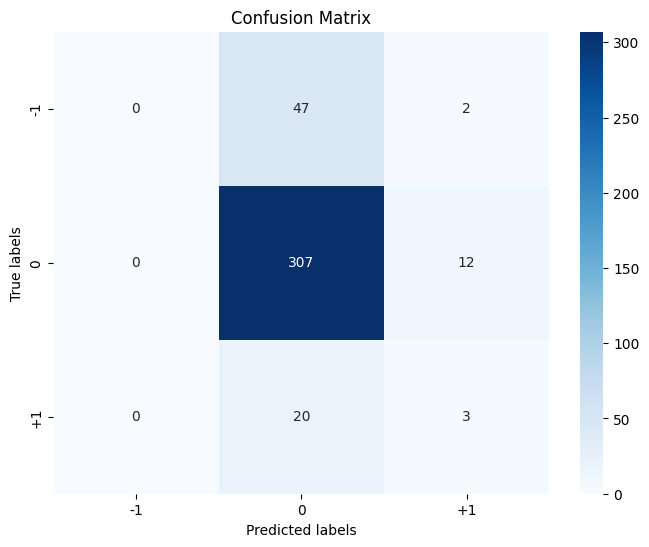

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_live_data(y_pred):
    pred_result = y_pred[['datetime', 'close', 'prediction']].copy()

    pred_target = get_target_next_close(pred_result)

    # Confusion report
    print("\nClassification Report:\n", classification_report(pred_target['target'], pred_target['prediction'], zero_division=0))

    # 1. Confusion Matrix
    conf_matrix = confusion_matrix(pred_target['target'], pred_target['prediction'])

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
                xticklabels=['-1', '0', '+1'], 
                yticklabels=['-1', '0', '+1'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_live_data(y_live_pred)

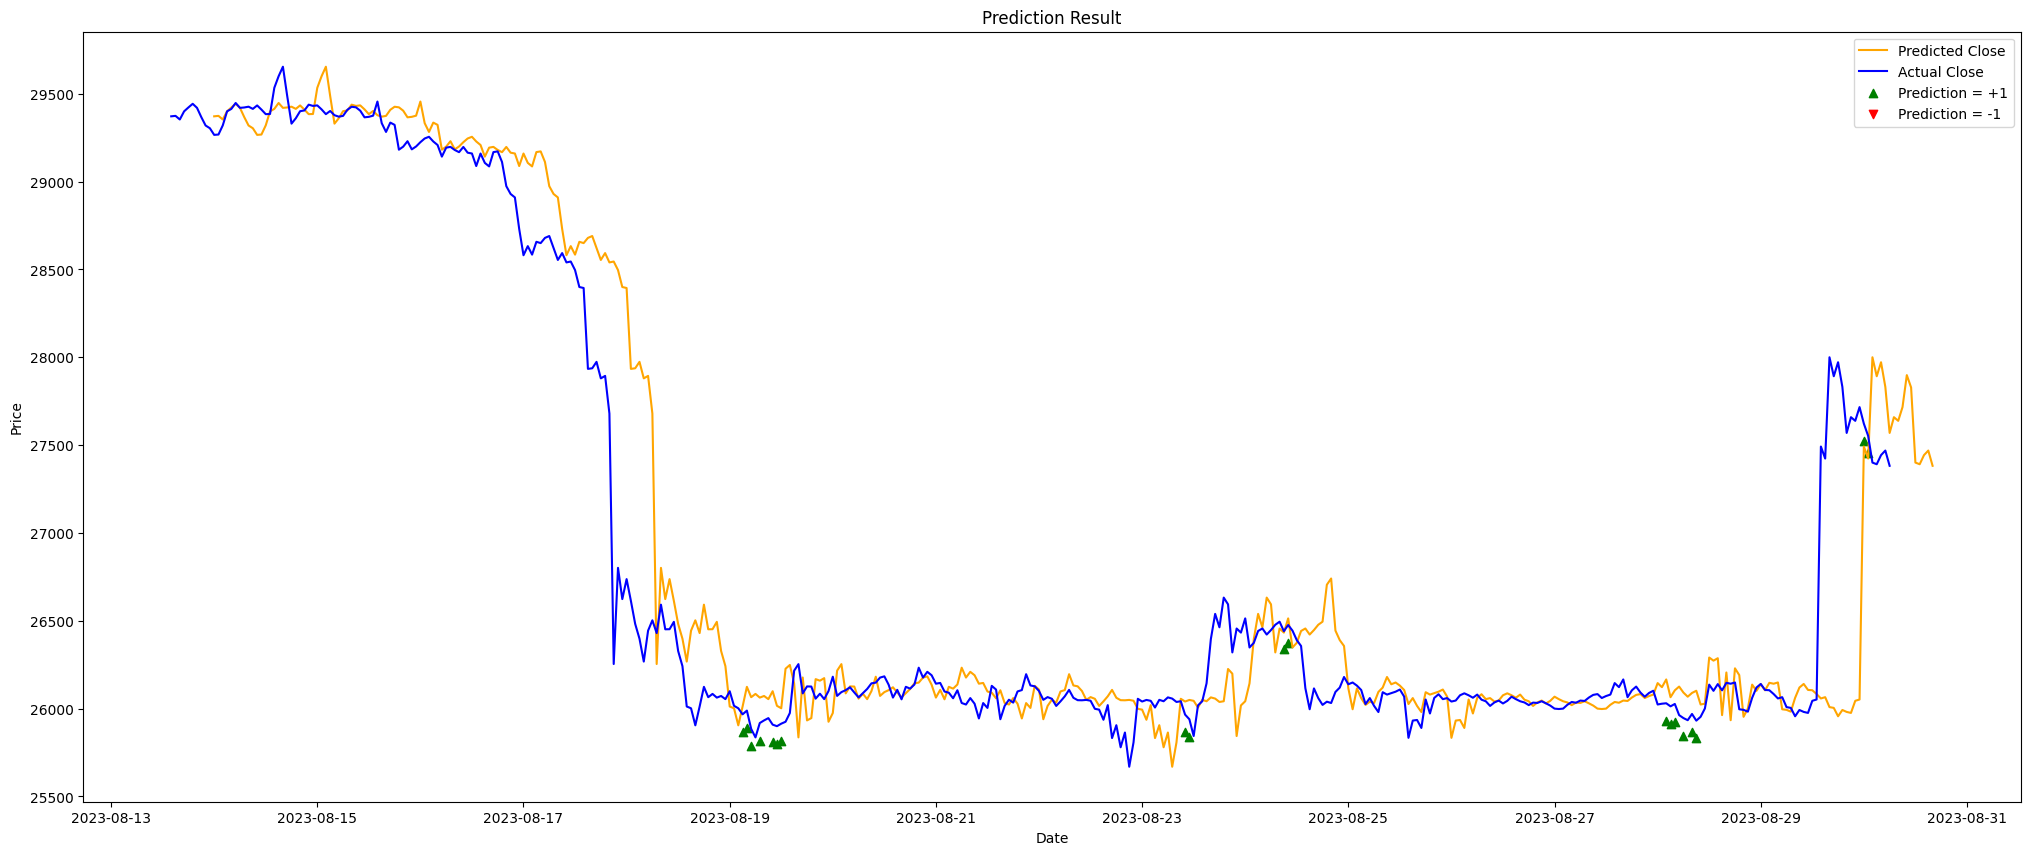

In [13]:
def plot_live_data(y_pred, target_treshold = 0.01, target_shift = 10):
    pred_result = y_pred[['datetime', 'close', 'prediction']].copy()

    # Calculate future close price, if prediction is 1, then close price will be 1% higher, if prediction is -1, then close price will be 1% lower
    pred_result['future_close'] = pred_result['close'] * (1 + pred_result['prediction'] * target_treshold)

    # Extend the prediction to the future
    date_range = pd.date_range(start=pred_result['datetime'].iloc[-1], periods=(target_shift+1), freq='H')
    # remove first row of date_range
    date_range = date_range[1:]

    pred_result_future = pd.DataFrame()
    pred_result_future['datetime'] = date_range
    pred_result_future['close'] = np.nan
    pred_result_future['prediction'] = np.nan
    pred_result_future['future_close'] = np.nan

    # concat pred_result and pred_result_future
    pred_result = pd.concat([pred_result, pred_result_future])

    # shift future_close 10 periods up
    pred_result['future_close'] = pred_result['future_close'].shift(target_shift)

    # plot 2 lines of close and future_close with sns
    plt.figure(figsize=(25, 10))
    
    sns.lineplot(data=pred_result, x='datetime', y='future_close', label='Predicted Close', color='orange')
    sns.lineplot(data=pred_result, x='datetime', y='close', label='Actual Close', color='blue')

    plt.scatter(
        pred_result[pred_result['prediction'] == 1]['datetime'], 
        pred_result[pred_result['prediction'] == 1]['close'] - 100, 
        color='green', 
        marker='^', 
        label='Prediction = +1'
    )

    # Plot scatter points for negative predictions
    plt.scatter(
        pred_result[pred_result['prediction'] == -1]['datetime'], 
        pred_result[pred_result['prediction'] == -1]['close'] + 100, 
        color='red', 
        marker='v',
        label='Prediction = -1'
    )

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Prediction Result')
    plt.legend()
    plt.show()


# print(y_live_pred.tail(5))
plot_live_data(y_live_pred)

##### Observations:

- Although the model shows a 79% accuracy on real-world data, this is largely driven by its performance on the majority class, `0` (no price change).

- Profiting from the majority class `0` is not practical.

- Limiting the training data up to July 19, 2023, has compromised the model's predictive power. Specifically:

    - The model failed to forecast the significant downturn from July 16 to August 18, 2023.
    
    - It also did not capture the price surge on August 29, 2023, reacting several hours after the fact.
    
- These shortcomings point to potential issues of overfitting and inadequate treatment of class imbalance for `+1` and `-1` categories.


##### Next Steps:

**1. Rethink Class Balancing Techniques:**

Although we currently use SMOTE for class balancing, it may not be ideal for our specific problem. We will experiment with other methods such as ADASYN.

**2. Feature Refinement:**

We will explore new feature engineering opportunities to better differentiate between the classes.

**3. Implement Cost-Sensitive Learning:**

Given the importance of `+1` and `-1` classes, we will consider cost-sensitive learning approaches that penalize misclassification of these critical classes more heavily.

**4. Hyperparameter Optimization:**

We will further fine-tune the model's hyperparameters with a focus on enhancing the F1-score for the classes `+1` and `-1`.

```python
# For example, when using Random Forest:
rf = RandomForestClassifier(class_weight={1:3, 0:1, -1:3})
```

**5. Tailored Evaluation Metrics:**

During the cross-validation process, we will employ custom metrics designed to underscore the performance on the critical classes. One option is a weighted F1-score.